In [42]:
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt
import torch
import pickle

from itertools import combinations
from tqdm import tqdm
from matplotlib.colors import LogNorm

molecule = "2JOF"
# molecule = "CLN025"

simulation_idx = 0

# Basics

0.9449426


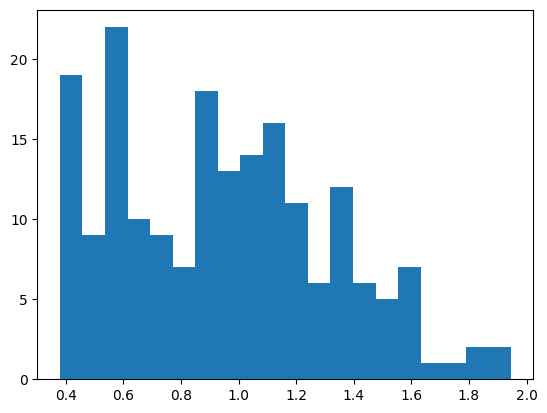

In [43]:
traj = md.load(
	f"/home/shpark/prj-mlcv/lib/DESRES/data/{molecule}/{molecule}_from_mae.pdb"
)
ca_resid_pair = np.array(
    [(a.index, b.index) for a, b in combinations(list(traj.topology.residues), 2)]
)
ca_distance, _ = md.compute_contacts(
	traj, scheme="ca", contacts=ca_resid_pair, periodic=False
)
print(ca_distance.mean())
plt.hist(ca_distance.flatten(), bins=20)
plt.show()

In [45]:
base_dir = f"../DESRES-Trajectory_{molecule}-0-protein"
pdb_file = f"../data/{molecule}/{molecule}_from_mae.pdb"
traj_list = []

for i in tqdm(
    range(53),
    desc="Loading trajectories"
):  # 0 to 52 inclusive
    file_idx = f"{i:03d}"
    traj = md.load_dcd(
        f"{base_dir}/{molecule}-0-protein/{molecule}-0-protein-{file_idx}.dcd",
        top=pdb_file,
    )
    traj_list.append(traj)

all_traj = md.join(traj_list)
print(f"Number of frames: {all_traj.n_frames}")

Loading trajectories: 100%|██████████| 53/53 [00:01<00:00, 28.74it/s]


Number of frames: 530000


In [ ]:
ca_resid_pair = np.array(
    [(a.index, b.index) for a, b in combinations(list(traj.topology.residues), 2)]
)
all_traj_ca_pair_distances, _ = md.compute_contacts(
	all_traj, scheme="ca", contacts=ca_resid_pair, periodic=False
)
print(all_traj_ca_pair_distances.shape)

(530000, 190)


In [ ]:
def cad2switch(
    cad,
    cutoff: float = 0.8
) -> np.ndarray:
	if type(cad) == torch.Tensor:
		cad = cad.numpy()
	return (1 - np.power(cad / cutoff, 6)) / (1 - np.power(cad / cutoff, 12))

In [ ]:
all_traj_ca_pair_distances_switch = cad2switch(all_traj_ca_pair_distances)

torch.save(torch.from_numpy(all_traj.xyz), f"/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_{molecule}-{simulation_idx}-protein/{molecule}-{simulation_idx}-pos-nano.pt")
torch.save(torch.from_numpy(all_traj_ca_pair_distances), f"/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_{molecule}-{simulation_idx}-protein/{molecule}-{simulation_idx}-CAdistance.pt")
torch.save(torch.from_numpy(all_traj_ca_pair_distances_switch), f"/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_{molecule}-{simulation_idx}-protein/{molecule}-{simulation_idx}-CAdistance-switch.pt")

In [53]:
loaded_xyz = torch.load(f"/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_{molecule}-{simulation_idx}-protein/{molecule}-{simulation_idx}-pos-nano.pt")
loaded_cad = torch.load(f"/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_{molecule}-{simulation_idx}-protein/{molecule}-{simulation_idx}-CAdistance.pt")
loaded_cad_switch = torch.load(f"/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_{molecule}-{simulation_idx}-protein/{molecule}-{simulation_idx}-CAdistance-switch.pt")

print(loaded_xyz.shape)
print(loaded_cad.shape)
print(loaded_cad_switch.shape)

torch.Size([530000, 272, 3])
torch.Size([530000, 190])
torch.Size([530000, 190])


In [55]:
torch.save(torch.from_numpy(all_traj.xyz), f"/home/shpark/prj-mlcv/lib/DESRES/dataset/{molecule}-all/pos.pt")
torch.save(torch.from_numpy(all_traj_ca_pair_distances), f"/home/shpark/prj-mlcv/lib/DESRES/dataset/{molecule}-all/cad.pt")
torch.save(torch.from_numpy(all_traj_ca_pair_distances_switch), f"/home/shpark/prj-mlcv/lib/DESRES/dataset/{molecule}-all/cad-switch.pt")

# Small size dataset generation

## Position and CAD

In [38]:
simulation_idx = 0
molecule_cad_path = f"/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_{molecule}-{simulation_idx}-protein/{molecule}-{simulation_idx}-CAdistance.pt"
molecule_pos_path = f"/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_{molecule}-{simulation_idx}-protein/{molecule}-{simulation_idx}-pos-nano.pt"
cad_data = torch.load(molecule_cad_path)
pos_data = torch.load(molecule_pos_path)

print(cad_data.shape)
print(pos_data.shape)

torch.Size([530000, 45])
torch.Size([530000, 166, 3])


In [39]:
def coord2rot(
    pdb,
    coordinates,
):
    ca_indices = pdb.topology.select('name CA')
    n_indices = pdb.topology.select('name N')
    c_indices = pdb.topology.select('name C')
    pdb_xyz = torch.tensor(coordinates)

    a = pdb_xyz[:, ca_indices]
    b = pdb_xyz[:, n_indices]
    c = pdb_xyz[:, c_indices]

    u = b - a  # C_alpha -> N
    v = c - a  # C_alpha -> C

    # Gram-Schmidt Process
    e1 = u / torch.norm(u, dim=-1, keepdim=True)
    u2 = v - torch.sum(e1 * v, dim=-1, keepdim=True) * e1
    e2 = u2 / torch.norm(u2, dim=-1, keepdim=True)
    e3 = torch.cross(e1, e2, dim=-1)

    Q = torch.stack([e1, e2, e3], dim=-1)

    return Q

In [40]:
pdb = md.load_pdb(pdb_file)
orientation = coord2rot(pdb, pos_data.numpy())

print(pos_data.shape)
print(orientation.shape)

torch.Size([530000, 166, 3])
torch.Size([530000, 10, 3, 3])


In [41]:
time_lag_list = [1, 5, 10, 100]
data_num = all_traj.n_frames
dataset_size = 5000
num_data_str = str(dataset_size // 1000) + "k"
selected_idx = torch.from_numpy(np.random.choice(data_num - max(time_lag_list) - 1, size = dataset_size, replace=False))

current_pos = pos_data[selected_idx]
current_cad = cad_data[selected_idx]
current_orientation = orientation[selected_idx]
torch.save(current_pos, f"/home/shpark/prj-mlcv/lib/DESRES/dataset/{molecule}-{num_data_str}/current-pos.pt")
torch.save(current_cad, f"/home/shpark/prj-mlcv/lib/DESRES/dataset/{molecule}-{num_data_str}/current-cad.pt")
torch.save(current_orientation, f"/home/shpark/prj-mlcv/lib/DESRES/dataset/{molecule}-{num_data_str}/current-orientation.pt")

for time_lag in time_lag_list:
	print(time_lag)
	next_pos = pos_data[selected_idx + time_lag]
	next_cad = cad_data[selected_idx + time_lag]
	next_orientation = orientation[selected_idx + time_lag]
	torch.save(next_pos, f"/home/shpark/prj-mlcv/lib/DESRES/dataset/{molecule}-{num_data_str}/lag{time_lag}-pos.pt")
	torch.save(next_cad, f"/home/shpark/prj-mlcv/lib/DESRES/dataset/{molecule}-{num_data_str}/lag{time_lag}-cad.pt")
	torch.save(next_orientation, f"/home/shpark/prj-mlcv/lib/DESRES/dataset/{molecule}-{num_data_str}/lag{time_lag}-orientation.pt")

1
5
10
100


## Label

In [9]:
def foldedness_by_hbond(
    traj,
    distance_cutoff=0.35,
    bond_number_cutoff=3
):
	"""
	Generate binary labels for folded/unfolded states based at least 3 bonds among eight bonds
	- TYR1T-YR10OT1
	- TYR1T-YR10OT2
	- ASP3N-TYR8O
	- THR6OG1-ASP3O
	- THR6N-ASP3OD1
	- THR6N-ASP3OD2
	- TYR10N-TYR1O


	Args:
		traj (mdtraj): mdtraj trajectory object
		distance_cutoff (float): donor-acceptor distance cutoff in nm (default 0.35 nm = 3.5 amstrong)
		angle_cutoff (float): hydrogen bond angle cutoff in degrees (default 110 deg)
		bond_number_cutoff (int): minimum number of bonds to be considered as folded (default 3)

	Returns:
		labels (np.array): binary array (1: folded, 0: unfolded)
	"""
	# TYR1N-YR10OT1
	donor_idx = traj.topology.select('residue 1 and name N')[0] # Tyr1:N
	acceptor_idx = traj.topology.select('residue 10 and name O')[0]   # Tyr10:OT1
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	label_O1 = ((distance[:,0] < distance_cutoff)).astype(int)
	label_O2 = ((distance[:,0] < distance_cutoff)).astype(int) 
	label_O3 = ((distance[:,0] < distance_cutoff)).astype(int)
	label_TYR1N_TYR10OT1 = label_O1 | label_O2 | label_O3


	# TYR1N-YR10OT2
	donor_idx = traj.topology.select('residue 1 and name N')[0] # Tyr1:N
	acceptor_idx = traj.topology.select('residue 10 and name OXT')[0]   # Tyr10:OT2
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	label_O1 = ((distance[:,0] < distance_cutoff)).astype(int)
	label_O2 = ((distance[:,0] < distance_cutoff)).astype(int)
	label_O3 = ((distance[:,0] < distance_cutoff)).astype(int)
	label_TYR1N_TYR10OT2 = label_O1 | label_O2 | label_O3


	# ASP3N-TYR8O
	donor_idx = traj.topology.select('residue 3 and name N')[0]
	acceptor_idx = traj.topology.select('residue 8 and name O')[0]
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	label_ASP3N_TYR8O = ((distance[:,0] < distance_cutoff)).astype(int)
 
 
	# THR6OG1-ASP3O
	donor_idx = traj.topology.select('residue 6 and name OG1')[0]
	acceptor_idx = traj.topology.select('residue 3 and name O')[0]
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	label_THR6OG1_ASP3O = ((distance[:,0] < distance_cutoff)).astype(int)
 
 
	# THR6N-ASP3OD1
	donor_idx = traj.topology.select('residue 6 and name N')[0]
	acceptor_idx = traj.topology.select('residue 3 and name OD1')[0]
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	label_THR6N_ASP3OD1 = ((distance[:,0] < distance_cutoff)).astype(int)
 
	# THR6N-ASP3OD2
	donor_idx = traj.topology.select('residue 6 and name N')[0]
	acceptor_idx = traj.topology.select('residue 3 and name OD2')[0]
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	label_THR6N_ASP3OD2 = ((distance[:,0] < distance_cutoff)).astype(int)
 
 
	# GLY7N-ASP3O
	donor_idx = traj.topology.select('residue 7 and name N')[0]
	acceptor_idx = traj.topology.select('residue 3 and name O')[0]
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	label_GLY7N_ASP3O = ((distance[:,0] < distance_cutoff)).astype(int)
 

	# TYR10N-TYR1O
	donor_idx = traj.topology.select('residue 10 and name N')[0] 
	acceptor_idx = traj.topology.select('residue 1 and name O')[0] 
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	label_TYR10N_TYR1O = ((distance[:,0] < distance_cutoff)).astype(int)




	# ASP3OD_THR6OG1_ASP3N_THR8O
	bond_sum = label_TYR1N_TYR10OT1 + label_TYR1N_TYR10OT2 + label_ASP3N_TYR8O + label_THR6OG1_ASP3O \
		+ label_THR6N_ASP3OD1 + label_THR6N_ASP3OD2 + label_GLY7N_ASP3O + label_TYR10N_TYR1O
	labels = bond_sum >= bond_number_cutoff

	# print(label_TYR10OT_TYR1N.sum())
	# print(labels_TYR10N_TYR1O.sum())
	# print(labels_ASP3OD_THR6OG1.sum())
	# print(labels_ASP3N_TYR8O.sum())

	return labels, bond_sum

In [ ]:
# Save label data

pdb = md.load(f"/home/shpark/prj-mlcv/lib/DESRES/data/{molecule}_desres.pdb")
current_pos = torch.load(f"/home/shpark/prj-mlcv/lib/DESRES/dataset/{molecule}-50k/current-pos.pt")
pdb.xyz = current_pos.numpy()
current_label, current_bond_num = foldedness_by_hbond(pdb)
torch.save(torch.from_numpy(current_label), f"/home/shpark/prj-mlcv/lib/DESRES/dataset/{molecule}-50k/current-label.pt")
torch.save(torch.from_numpy(current_bond_num), f"/home/shpark/prj-mlcv/lib/DESRES/dataset/{molecule}-50k/current-bondnum.pt")

for selected_lag in [1, 5, 10, 100]:
	time_lagged_pos = torch.load(f"/home/shpark/prj-mlcv/lib/DESRES/dataset/{molecule}-{num_data_str}/lag{selected_lag}-pos.pt")
	pdb.xyz = time_lagged_pos.numpy()
	time_lagged_label, time_lagged_bond_num = foldedness_by_hbond(pdb)
	torch.save(torch.from_numpy(time_lagged_label), f"/home/shpark/prj-mlcv/lib/DESRES/dataset/{molecule}-{num_data_str}/lag{selected_lag}-label.pt")
	torch.save(torch.from_numpy(time_lagged_bond_num), f"/home/shpark/prj-mlcv/lib/DESRES/dataset/{molecule}-{num_data_str}/lag{selected_lag}-bondnum.pt")

# Stats

## CAD, pos stats

In [14]:
dataset_size_str = "5k"
selected_lag = 5

current_pos = torch.load(f"/home/shpark/prj-mlcv/lib/DESRES/dataset/{molecule}-{dataset_size_str}/current-pos.pt")
current_cad = torch.load(f"/home/shpark/prj-mlcv/lib/DESRES/dataset/{molecule}-{dataset_size_str}/current-cad.pt")
time_lagged_pos = torch.load(f"/home/shpark/prj-mlcv/lib/DESRES/dataset/{molecule}-{dataset_size_str}/lag{selected_lag}-pos.pt")
time_lagged_cad = torch.load(f"/home/shpark/prj-mlcv/lib/DESRES/dataset/{molecule}-{dataset_size_str}/lag{selected_lag}-cad.pt")

print(current_pos.shape)
print(current_cad.shape)
print(time_lagged_pos.shape)
print(time_lagged_cad.shape)

torch.Size([5000, 272, 3])
torch.Size([5000, 190])
torch.Size([5000, 272, 3])
torch.Size([5000, 190])


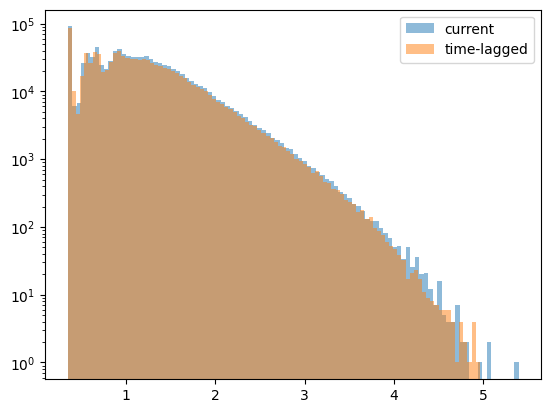

Current CAD mean: 1.1419
Time-lagged CAD mean: 1.1408
Current CAD max: 5.3994
Time-lagged CAD max: 4.9646


In [15]:
plt.hist(current_cad.flatten(), bins=100, alpha=0.5, log=True, label="current")
plt.hist(time_lagged_cad.flatten(), bins=100, alpha=0.5, log=True, label="time-lagged")
plt.legend()
plt.show()

print(f"Current CAD mean: {current_cad.mean():.4f}")
print(f"Time-lagged CAD mean: {time_lagged_cad.mean():.4f}")
print(f"Current CAD max: {current_cad.max():.4f}")
print(f"Time-lagged CAD max: {time_lagged_cad.max():.4f}")

## Foldedness and transitions

### CLN025

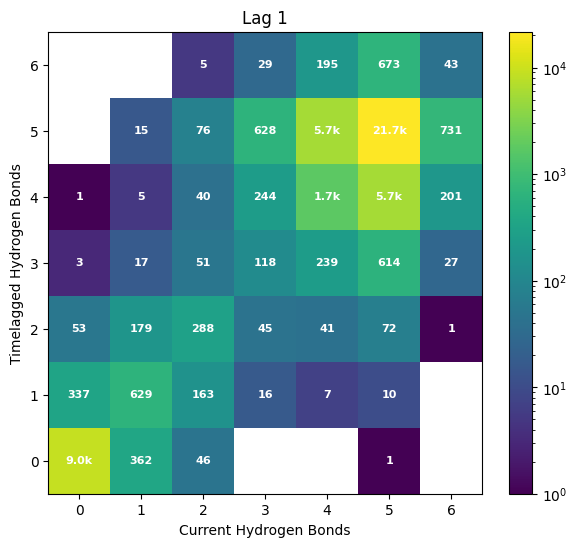

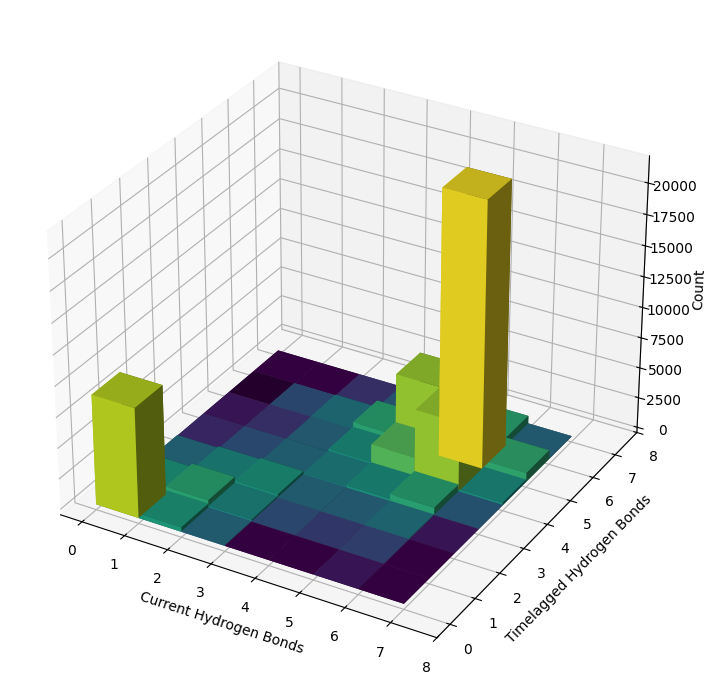

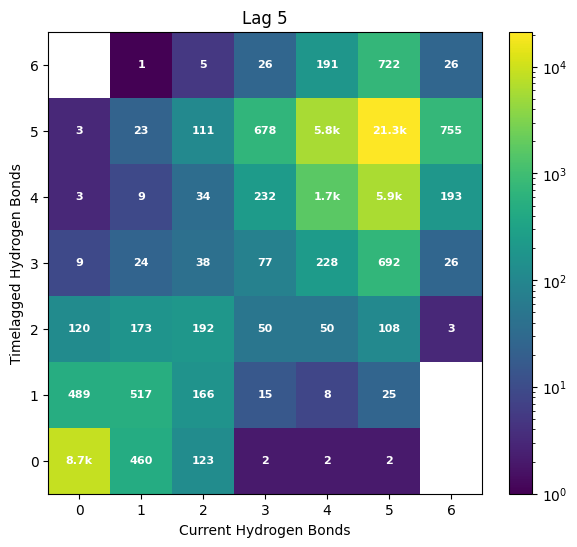

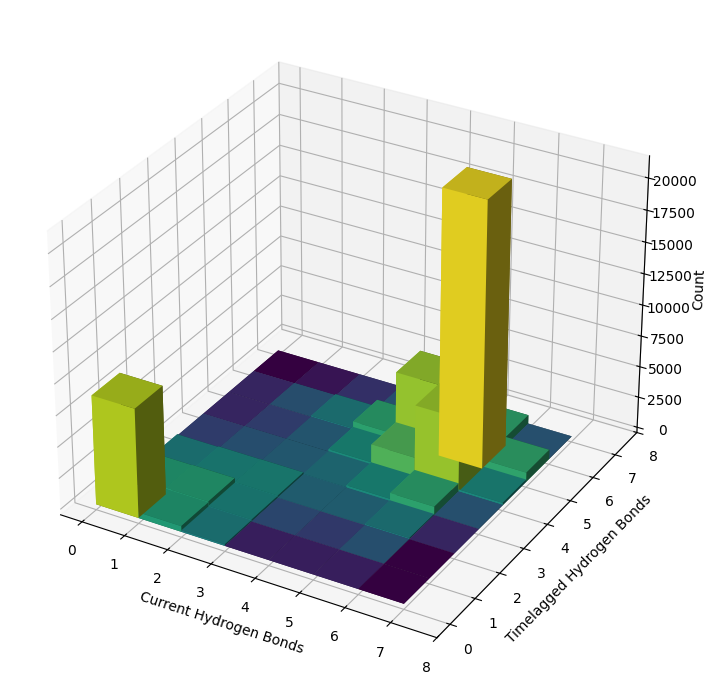

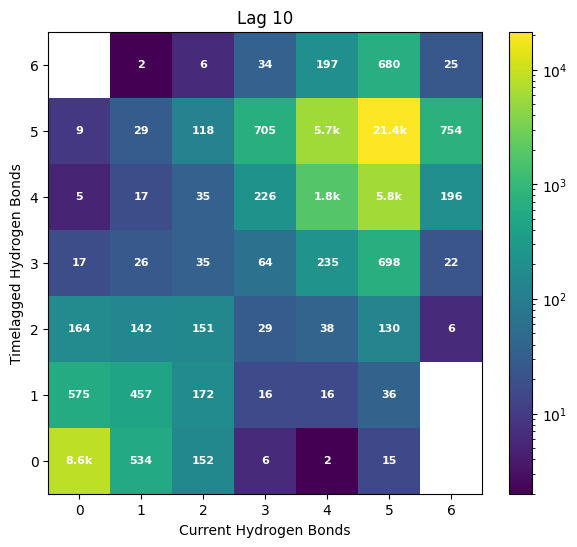

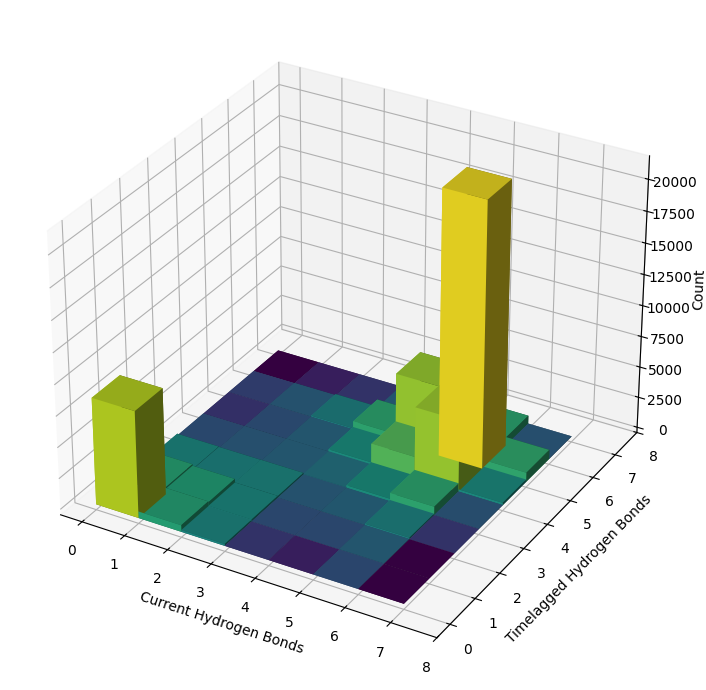

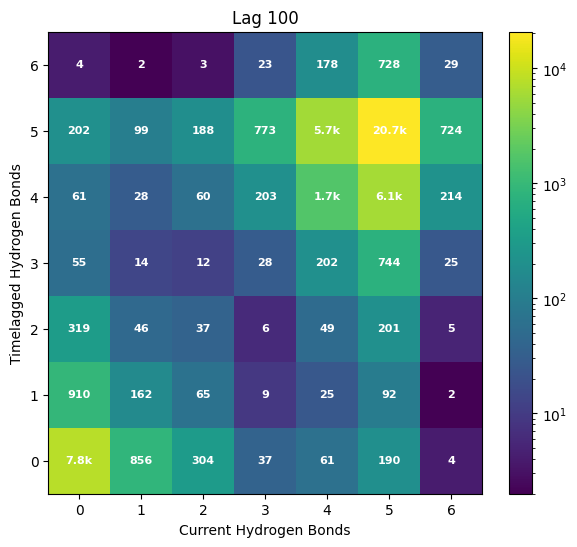

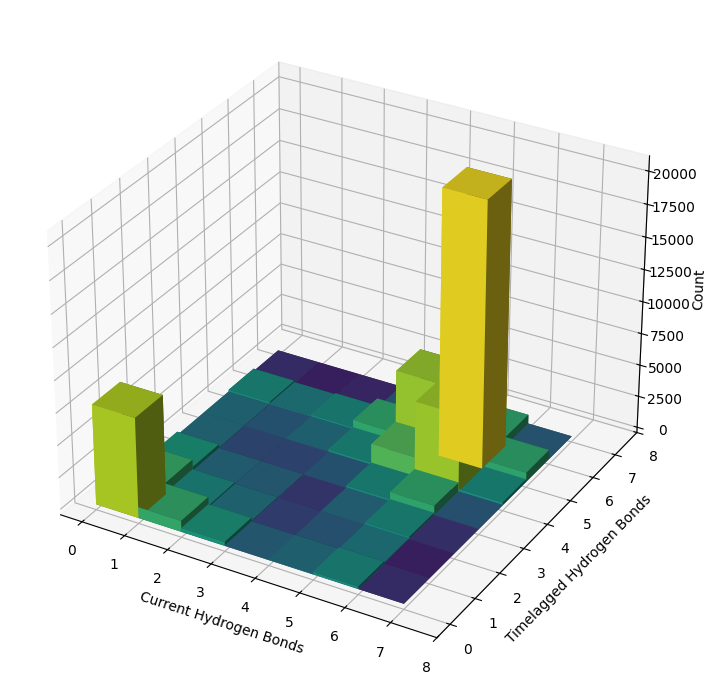

In [ ]:
dataset_size_str = "50k"
current_bond_num_path = f"/home/shpark/prj-mlcv/lib/DESRES/dataset/{molecule}-{dataset_size_str}/current-bondnum.pt"
current_bond_num = torch.load(current_bond_num_path)

def format_count(count):
    """Format count numbers in compact form (e.g., 5k, 1.2k, 500)"""
    if count >= 1000:
        return f"{count/1000:.1f}k".rstrip('0').rstrip('.')
    else:
        return str(int(count))

for time_lag in [1, 5, 10, 100]:
	time_lagged_bond_num_path = f"/home/shpark/prj-mlcv/lib/DESRES/dataset/{molecule}-{dataset_size_str}/lag{time_lag}-bondnum.pt"
	time_lagged_bond_num = torch.load(time_lagged_bond_num_path)
 
	fig = plt.figure(figsize=(7, 6))
	hist, xedges, yedges, _ = plt.hist2d(
		current_bond_num,
		time_lagged_bond_num,
		bins=[np.arange(-0.5,7.5,1), np.arange(-0.5,7.5,1)],
		norm=LogNorm()
	)
	
	# Add count numbers inside each square
	for i in range(len(xedges)-1):
		for j in range(len(yedges)-1):
			count = hist[i, j]
			if count > 0:  # Only show non-zero counts
				x_center = (xedges[i] + xedges[i+1]) / 2
				y_center = (yedges[j] + yedges[j+1]) / 2
				plt.text(x_center, y_center, format_count(count), 
						ha='center', va='center', fontsize=8, 
						color='white', weight='bold')
	
	plt.xlabel("Current Hydrogen Bonds")
	plt.ylabel("Timelagged Hydrogen Bonds")
	plt.title(f"Lag {time_lag}")
	plt.colorbar()
	plt.show()
 
	xpos, ypos = np.meshgrid(xedges[:-1] + 0.5, yedges[:-1] + 0.5, indexing="ij")
	xpos = xpos.ravel()
	ypos = ypos.ravel()
	zpos = np.zeros_like(xpos)
	dx = dy = 1
	dz = hist.ravel()

	# Plot
	fig = plt.figure(figsize=(10, 7))
	ax = fig.add_subplot(111, projection='3d')
	colors = plt.cm.viridis(np.log1p(dz) / np.log1p(dz.max()))
	ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=colors, zsort='average')
	ax.set_xlabel('Current Hydrogen Bonds')
	ax.set_ylabel('Timelagged Hydrogen Bonds')
	ax.set_zlabel('Count')
	ax.set_xticks(range(9))
	ax.set_yticks(range(9))
	plt.tight_layout()
	plt.show()

In [ ]:
current_label_path = f"/home/shpark/prj-mlcv/lib/DESRES/dataset/{molecule}-{dataset_size_str}/current-label.pt"
current_label = torch.load(current_label_path)

for time_lag in [1, 5, 10, 100]:
	time_lagged_label_path = f"/home/shpark/prj-mlcv/lib/DESRES/dataset/{molecule}-{dataset_size_str}/lag{time_lag}-label.pt"
	time_lagged_label = torch.load(time_lagged_label_path)

	print(f"\n <Lag {time_lag}>")
	folded2unfolded = (current_label == 1) & (time_lagged_label == 0)
	unfolded2folded = (current_label == 0) & (time_lagged_label == 1)
	transition_num = folded2unfolded.sum() + unfolded2folded.sum()

	print(f"Folded: {(current_label == 1).sum()}")
	print(f"Unfolded: {(current_label == 0).sum()}")
	# print(f"Unfolded: {current_label.shape[0] - current_label.sum()}")
	print(f"Folded2unfolded: {folded2unfolded.sum()} ({folded2unfolded.sum() / (current_label.shape[0]) * 100:.2f}%)")
	print(f"Unfolded2folded: {unfolded2folded.sum()} ({unfolded2folded.sum() / (current_label.shape[0]) * 100:.2f}%)")
	print(f"Transitions: {transition_num} / {current_label.shape[0]} ({transition_num / current_label.shape[0] * 100:.2f}%)")

	# plt.hist(current_bond_num, bins=bins, alpha=0.5, log=True, label="all")
	# plt.hist(current_bond_num[folded2unfolded], bins=bins, alpha=0.5, log=True, label="folded2unfolded")
	# plt.hist(current_bond_num[unfolded2folded], bins=bins, alpha=0.5, log=True, label="unfolded2folded")
	# plt.xticks(range(0, 7))
	# plt.legend()
	# plt.show()


 <Lag 1>
Folded: 38766
Unfolded: 11234
Folded2unfolded: 193 (0.39%)
Unfolded2folded: 213 (0.43%)
Transitions: 406 / 50000 (0.81%)

 <Lag 5>
Folded: 38766
Unfolded: 11234
Folded2unfolded: 265 (0.53%)
Unfolded2folded: 260 (0.52%)
Transitions: 525 / 50000 (1.05%)

 <Lag 10>
Folded: 38766
Unfolded: 11234
Folded2unfolded: 294 (0.59%)
Unfolded2folded: 299 (0.60%)
Transitions: 593 / 50000 (1.19%)

 <Lag 100>
Folded: 38766
Unfolded: 11234
Folded2unfolded: 681 (1.36%)
Unfolded2folded: 728 (1.46%)
Transitions: 1409 / 50000 (2.82%)


In [ ]:
current_label_path = f"/home/shpark/prj-mlcv/lib/DESRES/dataset/{molecule}-{dataset_size_str}/current-label.pt"
current_label = torch.load(current_label_path)
time_lag = 10
time_lagged_label_path = f"/home/shpark/prj-mlcv/lib/DESRES/dataset/{molecule}-{dataset_size_str}/lag{time_lag}-label.pt"
time_lagged_label = torch.load(time_lagged_label_path)

unfolded2folded = (current_label == 0) & (time_lagged_label == 1)
print(np.where(unfolded2folded)[0])
folded2unfolded = (current_label == 1) & (time_lagged_label == 0)
print(np.where(folded2unfolded)[0])
unfolded2unfolded = (current_label == 0) & (time_lagged_label == 0)
print(np.where(unfolded2unfolded)[0])
folded2folded = (current_label == 1) & (time_lagged_label == 1)
print(np.where(folded2folded)[0])

[  252   552   878  1181  1384  1395  1397  1480  2159  2202  2204  2307
  2413  2449  2570  2590  2672  2704  2760  2785  3306  3589  3681  3935
  4223  4371  4748  4780  5021  5142  5169  5190  5197  5241  5756  5913
  6082  6147  6199  6602  6743  6884  7020  7194  7734  7830  8046  8178
  8418  8595  8859  9168  9290  9397  9545  9697  9744  9757  9760  9839
  9867  9966 10139 10296 10332 10463 10518 10771 10811 10930 11061 11450
 12075 12098 12166 12236 12445 12712 12992 13056 13065 13195 13342 13542
 13601 13711 13821 13909 14013 14525 14873 15135 15266 15446 15664 15776
 16139 16361 16556 16660 16927 17351 17439 17763 17984 18005 18210 18252
 18416 18936 19002 19026 19072 19288 19511 19908 20095 20468 20743 20757
 20893 20967 21090 21239 21451 21601 21642 21721 21822 21932 22148 22291
 22590 22767 22794 22872 22906 23062 23198 23320 23687 23934 24182 24294
 24467 24508 24780 25141 25216 25558 25635 25650 25715 25771 26028 26639
 26950 27323 27387 27676 27886 27962 28418 28421 28

In [22]:
np.where(unfolded2unfolded)[0][:100]

array([  0,   4,   6,  12,  13,  19,  20,  21,  23,  24,  27,  37,  44,
        47,  56,  58,  63,  66,  69,  72,  83,  85,  86,  92,  94,  97,
        98, 115, 119, 131, 132, 135, 141, 146, 148, 152, 153, 154, 161,
       163, 165, 169, 171, 177, 181, 185, 192, 193, 195, 202, 204, 211,
       215, 216, 217, 224, 227, 242, 253, 265, 275, 278, 279, 292, 294,
       299, 302, 303, 305, 312, 313, 314, 318, 322, 325, 339, 345, 348,
       352, 355, 357, 361, 363, 380, 383, 384, 385, 386, 389, 390, 392,
       393, 396, 397, 402, 404, 407, 410, 414, 417])

### 2JOF

# Single data

### CLN025

In [ ]:
committor_path = "/home/shpark/prj-mlcv/lib/bioemu/notebook/committor.pt"
committor_model = torch.jit.load(committor_path)
print(committor_model)

tica_model_path = f"/home/shpark/prj-mlcv/lib/DESRES/data/{molecule}_tica_model_switch_lag5.pkl"
tica_model = pickle.load(open(tica_model_path, "rb"))
print(tica_model)

RecursiveScriptModule(
  original_name=NN_committor_guess
  (nn): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Linear)
    (1): RecursiveScriptModule(original_name=Tanh)
    (2): RecursiveScriptModule(original_name=Linear)
    (3): RecursiveScriptModule(original_name=Tanh)
    (4): RecursiveScriptModule(original_name=Linear)
    (5): RecursiveScriptModule(original_name=CustomActivation)
  )
)


In [104]:
folding_idx = 112
unfolding_idx = 483
folded_idx = 10
unfolded_idx = 130

torch.Size([5, 45])
(530000, 2)


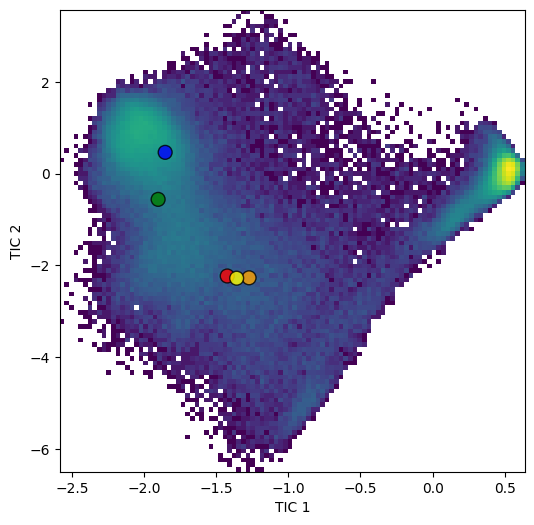

In [ ]:
dataset_size_str = "5k"
current_cad = torch.load(f"/home/shpark/prj-mlcv/lib/DESRES/dataset/{molecule}-{dataset_size_str}/current-cad.pt")
frame_idx = np.random.randint(0, current_cad.shape[0])
frame_idx = unfolded_idx

cad_data_over_time = [current_cad[frame_idx]]

for time_lag in [1, 5, 10, 100]:
	time_lagged_cad = torch.load(f"/home/shpark/prj-mlcv/lib/DESRES/dataset/{molecule}-{dataset_size_str}/lag{time_lag}-cad.pt")
	cad_data_over_time.append(time_lagged_cad[frame_idx])

cad_data_over_time = torch.stack(cad_data_over_time)
print(cad_data_over_time.shape)

data_all_path = f"/home/shpark/prj-mlcv/lib/DESRES/dataset/{molecule}-all/cad.pt"
data_all = torch.load(data_all_path).numpy()
data_all_switch = cad2switch(data_all)

tica_data = tica_model.transform(data_all_switch)
x = tica_data[:, 0]
y = tica_data[:, 1]
print(tica_data.shape)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.hist2d(x, y, bins=100, norm=LogNorm())
ax.set_xlabel("TIC 1")
ax.set_ylabel("TIC 2")
time_color = ["red", "orange", "yellow", "green", "blue"]
cad_data_over_time_switch = cad2switch(cad_data_over_time)
cad_tica_coord = tica_model.transform(cad_data_over_time_switch)
ax.scatter(cad_tica_coord[:, 0], cad_tica_coord[:, 1], s=100, alpha=0.8, c=time_color, edgecolors="black")
plt.show()

### 2JOF